Feature: Database
=================

The default behaviour of **PyAutoFit** is for model-fitting results to be output to hard-disc in folders, which are
straight forward to navigate and manually check the model-fitting results. For small model-fitting tasks this is
sufficient, however many users have a need to perform many model fits to very large datasets, making the manual
inspection of results time consuming.

PyAutoFit's database feature outputs all model-fitting results as a
sqlite3 (https://docs.python.org/3/library/sqlite3.html) relational database, such that all results
can be efficiently loaded into a Jupyter notebook or Python script for inspection, analysis and interpretation. This
database supports advanced querying, so that specific model-fits (e.g., which fit a certain model or dataset) can be
loaded.

This example extends our example of fitting a 1D `Gaussian` profile and fits 3 independent datasets each containing a
1D Gaussian. The results will be written to a `.sqlite` database, which we will load to demonstrate the database.

A full description of PyAutoFit's database tools is provided in the database chapter of the `HowToFit` lectures.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af

from os import path
import numpy as np

import model as m
import analysis as a

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


For each dataset we load it from hard-disc, set up its `Analysis` class and fit it with a non-linear search. 

The 3 datasets are in the `autofit_workspace/dataset/example_1d` folder.

We want each results to be stored in the database with an entry specific to the dataset. We'll use the `Dataset`'s name 
string to do this, so lets create a list of the 3 dataset names.

In [2]:
dataset_names = ["gaussian_x1_0", "gaussian_x1_1", "gaussian_x1_2"]

We can also attach information to the model-fit, by setting up an info dictionary. 

Information about our model-fit (e.g. the dataset) that isn't part of the model-fit is made accessible to the 
database. For example, below we write info on the dataset`s (hypothetical) data of observation and exposure time.

In [3]:
info = {"date_of_observation": "01-02-18", "exposure_time": 1000.0}

__Model__

Next, we create our model, which again corresponds to a single `Gaussian` with manual priors.

In [4]:
model = af.CollectionPriorModel(gaussian=m.Gaussian)

model.gaussian.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian.intensity = af.LogUniformPrior(lower_limit=1e-2, upper_limit=1e2)
model.gaussian.sigma = af.GaussianPrior(
    mean=10.0, sigma=5.0, lower_limit=0.0, upper_limit=np.inf
)

This for loop runs over every dataset, checkout the comments below for how we set up the database entry of each fit.

In [5]:
for dataset_name in dataset_names:

    """
    The code below loads the dataset and sets up the Analysis class.
    """
    dataset_path = path.join("dataset", "example_1d", dataset_name)

    data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
    noise_map = af.util.numpy_array_from_json(
        file_path=path.join(dataset_path, "noise_map.json")
    )

    analysis = a.Analysis(data=data, noise_map=noise_map)

    """
    In all examples so far, results have gone to the default output path, which was the `autofit_workspace/output` 
    folder and a folder named after the non linear search. In this example, we will repeat this process and then load
    these results into the database and a `database.sqlite` file.
    
    However, results can be written directly to the `database.sqlite` file omitted hard-disc output entirely, which
    can be important for performing large model-fitting tasks on high performance computing facilities where there
    may be limits on the number of files allowed. The commented out code below shows how one would perform
    direct output to the `.sqlite` file. 
    
    [NOTE: direct writing to .sqlite not supported yet, so this fit currently outputs to hard-disc as per usual and
    these outputs will be used to make the database.]
    """
    emcee = af.Emcee(
        paths=af.Paths(path_prefix=path.join("features", "database", dataset_name)),
        nwalkers=30,
        nsteps=1000,
        initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
        auto_correlation_check_for_convergence=True,
        auto_correlation_check_size=100,
        auto_correlation_required_length=50,
        auto_correlation_change_threshold=0.01,
        number_of_cores=1,
    )

    # INSERT CODE HERE.

    print(
        f"Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a "
        f"few minutes!"
    )

    result = emcee.fit(model=model, analysis=analysis, info=info)

print("Emcee has finished run - you may now continue the notebook.")

INFO:root: already completed, skipping non-linear search.


Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a few minutes!


INFO:root: already completed, skipping non-linear search.


Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a few minutes!


INFO:root: already completed, skipping non-linear search.


Emcee has begun running. This Jupyter notebook cell with progress once Emcee has completed, this could take a few minutes!
Emcee has finished run - you may now continue the notebook.


We now load the results in the `output` folder into a sqlite database using the `Aggregator`. We simply point to the 
path where we want the database to be created and add the directory `autofit_workspace/output/features/database`.

Checkout the output folder, you should see a `database.sqlite` file which contains the model-fits to the 3 `Gaussian`
datasets.

In [6]:
from autofit.database.aggregator import Aggregator

agg = Aggregator.from_database(
    path.join("output", "features", "database", "database.sqlite")
)

agg.add_directory(path.join("output", "features", "database"))

Aggregator loading phases... could take some time.

 A total of 3 phases and results were found.


Before using the aggregator to inspect results, let me quickly cover Python generators. A generator is an object that 
iterates over a function when it is called. The aggregator creates all of the objects that it loads from the database 
as generators (as opposed to a list, or dictionary, or other Python type).

Why? Because lists and dictionaries store every entry in memory simultaneously. If you fit many datasets, this will use 
a lot of memory and crash your laptop! On the other hand, a generator only stores the object in memory when it is used; 
Python is then free to overwrite it afterwards. Thus, your laptop won't crash!

There are two things to bare in mind with generators:

1) A generator has no length and to determine how many entries it contains you first must turn it into a list.

2) Once we use a generator, we cannot use it again and need to remake it. For this reason, we typically avoid 
 storing the generator as a variable and instead use the aggregator to create them on use.

We can now create a `samples` generator of every fit. As we saw in the `result.py` example scripts, an instance of 
the `Samples` class acts as an interface to the results of the non-linear search.

In [7]:
samples_gen = agg.values("samples")

When we convert this generator to a list and it, the outputs are 3 different MCMCSamples instances. These correspond to 
the 3 model-fits performed above.

In [8]:
print("Emcee Samples:\n")
print(samples_gen)
print("Total Samples Objects = ", len(list(samples_gen)), "\n")

Emcee Samples:

[<autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3ff5090430>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3ff1a161c0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3ff0763a30>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fef5382e0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fee464b50>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fed319580>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fec1c6c70>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3feb07b520>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe9fa6f10>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe8e5c640>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe7d08fa0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe6bbe760>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe5a73190>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3f

The `Samples` class is described in the `result.py` example script. Using the `Aggregator` we can access all of the 
attributes described in that example, for example the value of every parameter.

Refer to `result.py` for all the properties that are accessible via the `Aggregator`.

In [9]:
for samples in agg.values("samples"):
    print("All parameters of the very first sample")
    print(samples.parameters[0])
    print("The tenth sample`s third parameter")
    print(samples.parameters[9][2], "\n")

All parameters of the very first sample
[50.17570416290228, 0.9869558089032396, 10.0276991964512]
The tenth sample`s third parameter
10.111223683209603 

All parameters of the very first sample
[49.36700833150672, 0.9865358491589005, 10.062404606622472]
The tenth sample`s third parameter
9.9702230803709 

All parameters of the very first sample
[50.307614307571505, 0.9524003937708843, 10.12258470559654]
The tenth sample`s third parameter
10.08859498007356 

All parameters of the very first sample
[50.17570416290228, 0.9869558089032396, 10.0276991964512]
The tenth sample`s third parameter
10.111223683209603 

All parameters of the very first sample
[49.36700833150672, 0.9865358491589005, 10.062404606622472]
The tenth sample`s third parameter
9.9702230803709 

All parameters of the very first sample
[50.307614307571505, 0.9524003937708843, 10.12258470559654]
The tenth sample`s third parameter
10.08859498007356 

All parameters of the very first sample
[50.17570416290228, 0.98695580890323

__Querying__

We can use the `Aggregator`'s to query the database and return only specific fits that we are interested in. We first 
do this, using the `info` object, whereby we can query any of its entries, for example the `dataset_name` string we 
input into the model-fit above. 

By querying using the string `gaussian_x1_1` the model-fit to only the second `Gaussian` dataset is returned:

In [10]:
# FEature Missing

# agg_query = agg.query(agg.directory.contains("gaussian_x1_1"))
# samples_gen = agg_query.values("samples")

As expected, this list now has only 1 MCMCSamples corresponding to the second dataset.

In [11]:
print(samples_gen)
print("Total Samples Objects via dataset_name Query = ", len(list(samples_gen)), "\n")

[<autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3ff5090430>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3ff1a161c0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3ff0763a30>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fef5382e0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fee464b50>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fed319580>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fec1c6c70>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3feb07b520>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe9fa6f10>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe8e5c640>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe7d08fa0>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe6bbe760>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe5a73190>, <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x7f3fe49a0880>, <auto

We can also query based on the model fitted. 

For example, we can load all results which fitted a `Gaussian` model-component, which in this simple example is all
3 model-fits.
 
The ability to query via the model is extremely powerful. It enalbes a user to perform many model-fits with many 
different model parameterizations to large datasets and efficiently load and inspect the results. 

[Note: the code `agg.gaussian` corresponds to the fact that in the `CollectionPriorModel` above, we named the model
component `gaussian`. If this `CollectionPriorModel` had used a different name the code below would change 
correspondingly. Models with multiple model components (e.g., `gaussian` and `exponential`) are therefore also easily 
accessed via the database.]

In [12]:
gaussian = agg.gaussian
agg_query = agg.query(gaussian == m.Gaussian)
samples_gen = agg_query.values("samples")
print("Total Samples Objects via `Gaussian` model query = ", len(list(samples_gen)), "\n")

Total Samples Objects via `Gaussian` model query =  18 



Queries using the results of model-fitting are also supported. Below, we query the database to find all fits where the 
inferred value of `sigma` for the `Gaussian` is less than 3.0 (which returns only the first of the three model-fits).

In [13]:
gaussian = agg.gaussian
agg_query = agg.query(gaussian.sigma < 3.0)
samples_gen = agg_query.values("samples")
print("Total Samples Objects In Query `gaussian.sigma < 3.0` = ", len(list(samples_gen)), "\n")

Total Samples Objects In Query `gaussian.sigma < 3.0` =  0 



Advanced queries can be constructed using logic, for example we below we combine the two queries above to find all
results which fitted a `Gaussian` AND (using the & symbol) inferred a value of sigma less than 3.0. 

The OR logical clause is also supported via the symbol |.

In [14]:
gaussian = agg.gaussian
agg_query = agg.query((gaussian == m.Gaussian) & (gaussian.sigma < 3.0))
samples_gen = agg_query.values("samples")
print("Total Samples Objects In Query `Gaussian & sigma < 3.0` = ", len(list(samples_gen)), "\n")

Total Samples Objects In Query `Gaussian & sigma < 3.0` =  0 



Tutorial 3 complete! 

The API for querying is fairly self explanatory. Through the combination of info based queries, model based
queries and result based queries a user has all the tools they need to fit extremely large datasets with many different
models and load only the results they are interested in for inspection and analysis.

Lets next try something more ambitious and create a plot of the inferred sigma values vs intensity of each
Gaussian profile, including error bars at 3 sigma confidence.

This will use many of the methods described in the `result.py` example scripts, so if anything below appears new or
unclear checkout that script for a explanation.

[<autofit.mapper.model.ModelInstance object at 0x7f3ff18824c0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55c40>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55cd0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55d60>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55df0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55e80>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55f10>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55fa0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d559d0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55a30>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d55b20>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d5d220>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d5d2b0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d5d340>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7d5d3d0>, <autofit.mapper.model.ModelInstance object at 0x7f3fe7

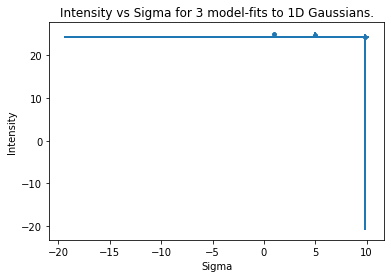

In [15]:
import matplotlib.pyplot as plt

mp_instances = [samps.median_pdf_instance for samps in agg.values("samples")]
ue3_instances = [
    out.error_instance_at_upper_sigma(sigma=3.0) for out in agg.values("samples")
]
le3_instances = [
    out.error_instance_at_lower_sigma(sigma=3.0) for out in agg.values("samples")
]

print(mp_instances)

mp_sigmas = [instance.gaussian.sigma for instance in mp_instances]
ue3_sigmas = [instance.gaussian.sigma for instance in ue3_instances]
le3_sigmas = [instance.gaussian.sigma for instance in le3_instances]
mp_intensitys = [instance.gaussian.intensity for instance in mp_instances]
ue3_intensitys = [instance.gaussian.intensity for instance in ue3_instances]
le3_intensitys = [instance.gaussian.intensity for instance in le3_instances]

plt.errorbar(
    x=mp_sigmas,
    y=mp_intensitys,
    marker=".",
    linestyle="",
    xerr=[le3_sigmas, ue3_sigmas],
    yerr=[le3_intensitys, ue3_intensitys],
)
plt.title("Intensity vs Sigma for 3 model-fits to 1D Gaussians.")
plt.ylabel("Intensity")
plt.xlabel("Sigma")
plt.show()

The Probability Density Functions (PDF's) of the results can be plotted using the library:

 corner.py: https://corner.readthedocs.io/en/latest/

(In built visualization for PDF's and non-linear searches is a future feature of PyAutoFit, but for now you`ll have to 
use the libraries yourself!).

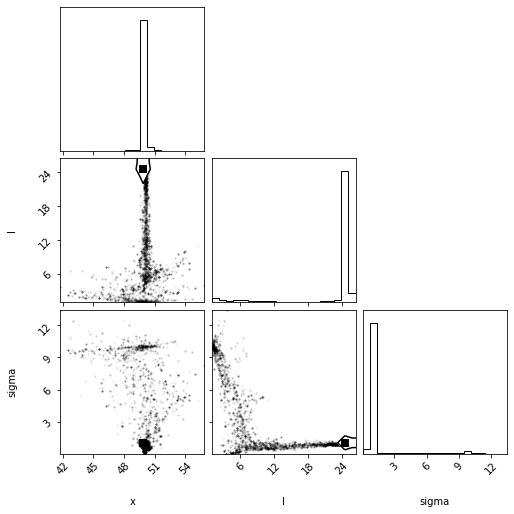

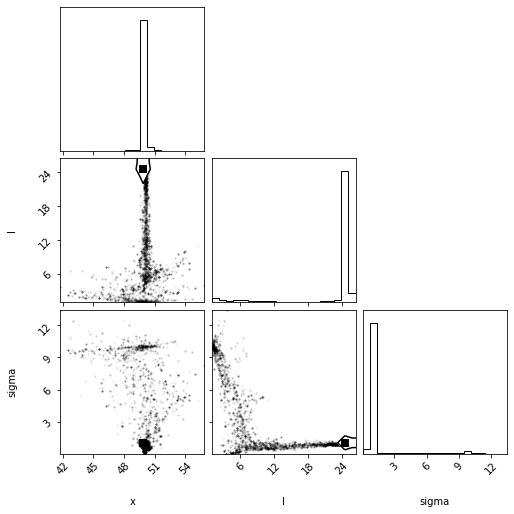

In [16]:
import corner

samples = list(agg.values("samples"))[0]

corner.corner(
    xs=samples.parameters,
    weights=samples.weights,
    labels=samples.model.parameter_labels,
)

The Database chapter of the **HowToFit** Jupyter notebooks give a full description of the database feature, including 
examples of advanced queries and how to load and plot the results of a model-fit in more detail.